In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from bart_playground import *
import bartz
from stochtree import BARTModel
import time

## California Housing Data

In [2]:
from sklearn.datasets import fetch_california_housing

data = fetch_california_housing(as_frame=True)

X = data.data
y = data.target

In [3]:
X

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25
...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32


In [4]:
y

0        4.526
1        3.585
2        3.521
3        3.413
4        3.422
         ...  
20635    0.781
20636    0.771
20637    0.923
20638    0.847
20639    0.894
Name: MedHouseVal, Length: 20640, dtype: float64

In [5]:
print(X.describe())

             MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  20640.000000  20640.000000  20640.000000  20640.000000  20640.000000   
mean       3.870671     28.639486      5.429000      1.096675   1425.476744   
std        1.899822     12.585558      2.474173      0.473911   1132.462122   
min        0.499900      1.000000      0.846154      0.333333      3.000000   
25%        2.563400     18.000000      4.440716      1.006079    787.000000   
50%        3.534800     29.000000      5.229129      1.048780   1166.000000   
75%        4.743250     37.000000      6.052381      1.099526   1725.000000   
max       15.000100     52.000000    141.909091     34.066667  35682.000000   

           AveOccup      Latitude     Longitude  
count  20640.000000  20640.000000  20640.000000  
mean       3.070655     35.631861   -119.569704  
std       10.386050      2.135952      2.003532  
min        0.692308     32.540000   -124.350000  
25%        2.429741     33.930000   -1

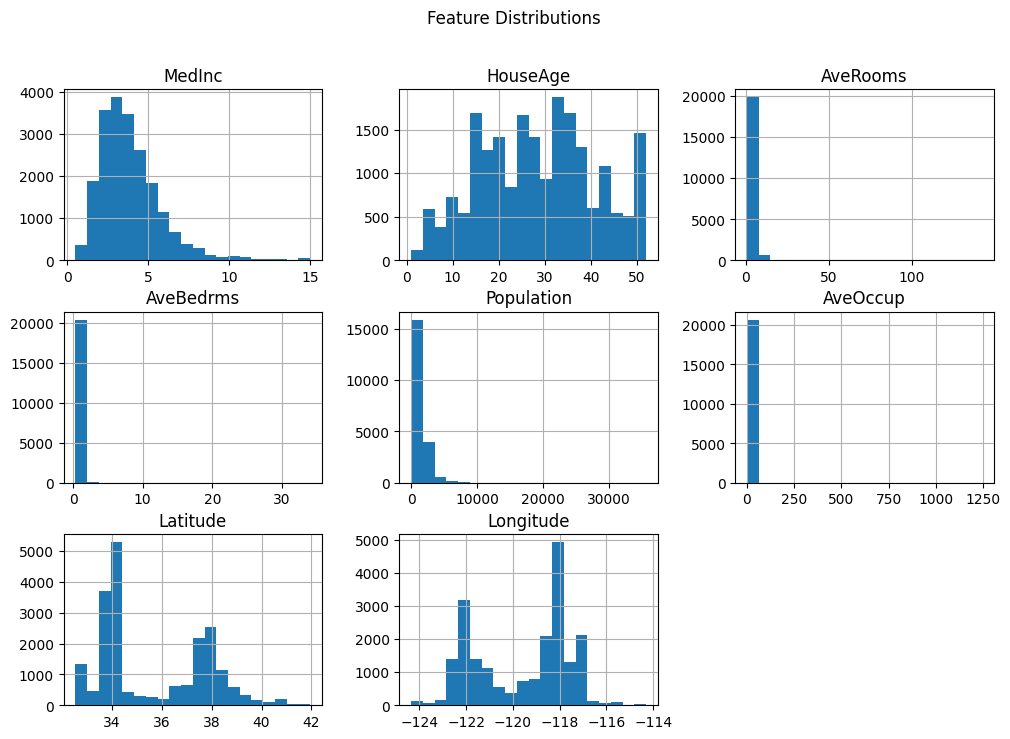

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

X.hist(figsize=(12, 8), bins=20)
plt.suptitle("Feature Distributions")
plt.show()

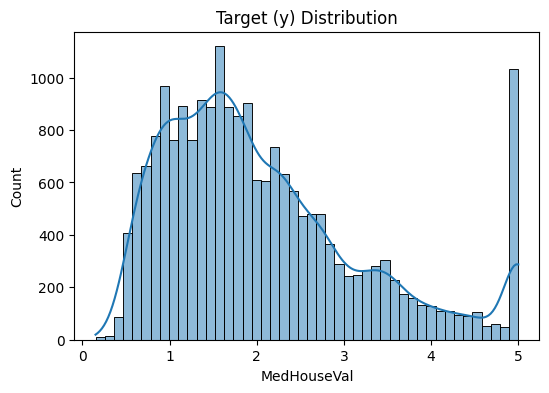

In [7]:
plt.figure(figsize=(6, 4))
sns.histplot(y, kde=True)
plt.title("Target (y) Distribution")
plt.show()

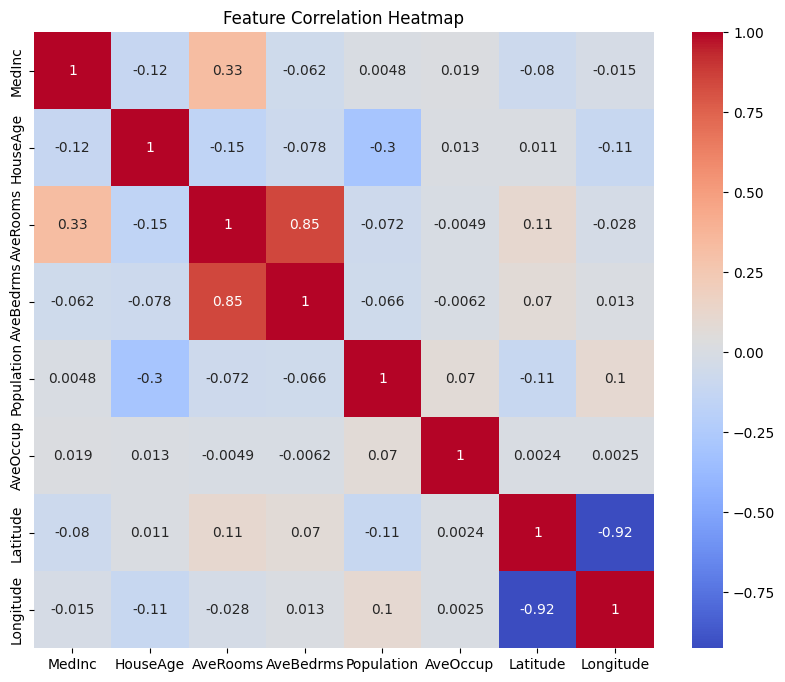

In [8]:
plt.figure(figsize=(10, 8))
corr = X.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

In [9]:
X = X.values.astype(float)
y = np.array(y).reshape(-1)

In [10]:
test_mse_results = {name: [] for name in ["bart", "btz", "sto", "rf", "xgb", "lr"]}
train_mse_results = {name: [] for name in ["bart", "btz", "sto", "rf", "xgb", "lr"]}
pi_length_results = {name: [] for name in ["bart", "btz", "sto"]}
coverage_results = {name: [] for name in ["bart", "btz", "sto"]}
time_results = {name: [] for name in ["bart", "btz", "sto", "rf", "xgb", "lr"]}

In [11]:
n_runs = 10
n_skip = 100
n_post = 200
n_trees = 100
for seed in range(n_runs):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed)
    
    # bart
    t0 = time.time()
    bart = DefaultBART(ndpost=n_post, nskip=n_skip, n_trees=n_trees)
    bart.fit(X_train, y_train)
    time_results["bart"].append(time.time() - t0)
    
    # btz
    t0 = time.time()
    btz = bartz.BART.gbart(np.transpose(X_train), y_train, ntree=n_trees, ndpost=n_post, nskip=n_skip)
    btpred_all_test = btz.predict(np.transpose(X_test))
    btpred_test = np.mean(np.array(btpred_all_test), axis=0)
    btpred_all_train = btz.predict(np.transpose(X_train))
    btpred_train = np.mean(np.array(btpred_all_train), axis=0)
    time_results["btz"].append(time.time() - t0)
    
    # sto
    t0 = time.time()
    sto = BARTModel()
    sto.sample(X_train=X_train, y_train=y_train,
               num_gfr=0, num_burnin=n_skip, num_mcmc=n_post, 
               mean_forest_params={"num_trees": n_trees})
    sto_pred_all_test = sto.predict(X_test)
    sto_pred_test = np.mean(sto_pred_all_test, axis=1)
    sto_pred_train = np.mean(sto.predict(X_train), axis=1)
    time_results["sto"].append(time.time() - t0)

    # rf
    t0 = time.time()
    rf = RandomForestRegressor(n_estimators=n_trees, random_state=seed)
    rf.fit(X_train, y_train)
    time_results["rf"].append(time.time() - t0)

    # xgb
    t0 = time.time()
    xgbr = xgb.XGBRegressor(n_estimators=n_trees, random_state=seed, verbosity=0)
    xgbr.fit(X_train, y_train)
    time_results["xgb"].append(time.time() - t0)

    # lr
    t0 = time.time()
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    time_results["lr"].append(time.time() - t0)
    
    # Test MSE
    test_mse_results["bart"].append(mean_squared_error(y_test, bart.predict(X_test)))
    test_mse_results["btz"].append(mean_squared_error(y_test, btpred_test))
    test_mse_results["sto"].append(mean_squared_error(y_test, sto_pred_test))
    test_mse_results["rf"].append(mean_squared_error(y_test, rf.predict(X_test)))
    test_mse_results["xgb"].append(mean_squared_error(y_test, xgbr.predict(X_test)))
    test_mse_results["lr"].append(mean_squared_error(y_test, lr.predict(X_test)))

    # Train MSE
    train_mse_results["bart"].append(mean_squared_error(y_train, bart.predict(X_train)))
    train_mse_results["btz"].append(mean_squared_error(y_train, btpred_train))
    train_mse_results["sto"].append(mean_squared_error(y_train, sto_pred_train))
    train_mse_results["rf"].append(mean_squared_error(y_train, rf.predict(X_train)))
    train_mse_results["xgb"].append(mean_squared_error(y_train, xgbr.predict(X_train)))
    train_mse_results["lr"].append(mean_squared_error(y_train, lr.predict(X_train)))

    # Prediction intervals
    # btz: axis=0, shape (n_mcmc, n_test)
    btz_lower = np.percentile(btpred_all_test, 2.5, axis=0)
    btz_upper = np.percentile(btpred_all_test, 97.5, axis=0)
    pi_length_results["btz"].append(np.mean(btz_upper - btz_lower))
    btz_covered = ((y_test >= btz_lower) & (y_test <= btz_upper)).mean()
    coverage_results["btz"].append(btz_covered)
    
    # sto: axis=1, shape (n_test, n_mcmc)
    sto_lower = np.percentile(sto_pred_all_test, 2.5, axis=1)
    sto_upper = np.percentile(sto_pred_all_test, 97.5, axis=1)
    pi_length_results["sto"].append(np.mean(sto_upper - sto_lower))
    sto_covered = ((y_test >= sto_lower) & (y_test <= sto_upper)).mean()
    coverage_results["sto"].append(sto_covered)
    
    # bart: axis=1, shape (n_test, n_mcmc)
    bart_pred_all_test = bart.posterior_f(X_test)
    bart_lower = np.percentile(bart_pred_all_test, 2.5, axis=1)
    bart_upper = np.percentile(bart_pred_all_test, 97.5, axis=1)
    pi_length_results["bart"].append(np.mean(bart_upper - bart_lower))
    bart_covered = ((y_test >= bart_lower) & (y_test <= bart_upper)).mean()
    coverage_results["bart"].append(bart_covered)


Iterations: 100%|██████████| 300/300 [01:34<00:00,  3.16it/s]
INFO:2025-05-29 16:53:42,907:jax._src.xla_bridge:927: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:2025-05-29 16:53:42,910:jax._src.xla_bridge:927: Unable to initialize backend 'tpu': UNIMPLEMENTED: LoadPjrtPlugin is not implemented on windows yet.
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': UNIMPLEMENTED: LoadPjrtPlugin is not implemented on windows yet.


Iteration 100/300 P_grow=0.56 P_prune=0.44 A_grow=0.18 A_prune=0.11 (burnin)
Iteration 200/300 P_grow=0.56 P_prune=0.44 A_grow=0.11 A_prune=0.14
Iteration 300/300 P_grow=0.56 P_prune=0.44 A_grow=0.11 A_prune=0.14


Iterations: 100%|██████████| 300/300 [01:30<00:00,  3.30it/s]


Iteration 100/300 P_grow=0.58 P_prune=0.42 A_grow=0.16 A_prune=0.14 (burnin)
Iteration 200/300 P_grow=0.57 P_prune=0.43 A_grow=0.11 A_prune=0.14
Iteration 300/300 P_grow=0.54 P_prune=0.46 A_grow=0.07 A_prune=0.13


Iterations: 100%|██████████| 300/300 [01:34<00:00,  3.19it/s]


Iteration 100/300 P_grow=0.57 P_prune=0.43 A_grow=0.12 A_prune=0.14 (burnin)
Iteration 200/300 P_grow=0.55 P_prune=0.45 A_grow=0.11 A_prune=0.22
Iteration 300/300 P_grow=0.57 P_prune=0.43 A_grow=0.07 A_prune=0.07


Iterations: 100%|██████████| 300/300 [01:34<00:00,  3.18it/s]


Iteration 100/300 P_grow=0.57 P_prune=0.43 A_grow=0.09 A_prune=0.14 (burnin)
Iteration 200/300 P_grow=0.56 P_prune=0.44 A_grow=0.07 A_prune=0.09
Iteration 300/300 P_grow=0.54 P_prune=0.46 A_grow=0.11 A_prune=0.02


Iterations: 100%|██████████| 300/300 [01:28<00:00,  3.39it/s]


Iteration 100/300 P_grow=0.61 P_prune=0.39 A_grow=0.15 A_prune=0.21 (burnin)
Iteration 200/300 P_grow=0.55 P_prune=0.45 A_grow=0.13 A_prune=0.13
Iteration 300/300 P_grow=0.55 P_prune=0.45 A_grow=0.09 A_prune=0.16


Iterations: 100%|██████████| 300/300 [01:29<00:00,  3.34it/s]


Iteration 100/300 P_grow=0.57 P_prune=0.43 A_grow=0.07 A_prune=0.09 (burnin)
Iteration 200/300 P_grow=0.58 P_prune=0.42 A_grow=0.16 A_prune=0.19
Iteration 300/300 P_grow=0.57 P_prune=0.43 A_grow=0.18 A_prune=0.12


Iterations: 100%|██████████| 300/300 [01:29<00:00,  3.37it/s]


Iteration 100/300 P_grow=0.58 P_prune=0.42 A_grow=0.16 A_prune=0.14 (burnin)
Iteration 200/300 P_grow=0.57 P_prune=0.43 A_grow=0.09 A_prune=0.14
Iteration 300/300 P_grow=0.55 P_prune=0.45 A_grow=0.04 A_prune=0.09


Iterations: 100%|██████████| 300/300 [01:21<00:00,  3.68it/s]


Iteration 100/300 P_grow=0.57 P_prune=0.43 A_grow=0.18 A_prune=0.05 (burnin)
Iteration 200/300 P_grow=0.56 P_prune=0.44 A_grow=0.11 A_prune=0.18
Iteration 300/300 P_grow=0.54 P_prune=0.46 A_grow=0.19 A_prune=0.07


Iterations: 100%|██████████| 300/300 [01:35<00:00,  3.14it/s]


Iteration 100/300 P_grow=0.56 P_prune=0.44 A_grow=0.14 A_prune=0.11 (burnin)
Iteration 200/300 P_grow=0.56 P_prune=0.44 A_grow=0.12 A_prune=0.16
Iteration 300/300 P_grow=0.56 P_prune=0.44 A_grow=0.14 A_prune=0.02


Iterations: 100%|██████████| 300/300 [01:36<00:00,  3.12it/s]


Iteration 100/300 P_grow=0.55 P_prune=0.45 A_grow=0.13 A_prune=0.09 (burnin)
Iteration 200/300 P_grow=0.57 P_prune=0.43 A_grow=0.19 A_prune=0.16
Iteration 300/300 P_grow=0.59 P_prune=0.41 A_grow=0.08 A_prune=0.17


In [12]:
import pandas as pd

test_mse_df = pd.DataFrame(test_mse_results)
train_mse_df = pd.DataFrame(train_mse_results)
pi_length_df = pd.DataFrame(pi_length_results)
coverage_df = pd.DataFrame(coverage_results)
time_df = pd.DataFrame(time_results)

print(f"Test MSE ({n_runs} runs):")
print(f"Train MSE ({n_runs} runs):")
print("Test MSE Mean:")
print(test_mse_df.mean())
print("Train MSE Mean:")
print(train_mse_df.mean())

print(f"Prediction Interval Mean Length ({n_runs} runs):")
print(f"Prediction Interval Mean Length (Mean over {n_runs} runs):")
print(pi_length_df.mean())

print(f"Prediction Interval Coverage Mean ({n_runs} runs):")
print(coverage_df.mean())

print(f"Average Training Time (seconds) over {n_runs} runs:")
print(time_df.mean())

Test MSE (10 runs):
Train MSE (10 runs):
Test MSE Mean:
bart    0.251035
btz     0.309190
sto     0.312083
rf      0.260956
xgb     0.221331
lr      0.536154
dtype: float64
Train MSE Mean:
bart    0.215472
btz     0.285858
sto     0.282982
rf      0.035877
xgb     0.070743
lr      0.521410
dtype: float64
Prediction Interval Mean Length (10 runs):
Prediction Interval Mean Length (Mean over 10 runs):
bart    0.338525
btz     0.346869
sto     0.437351
dtype: float64
Prediction Interval Coverage Mean (10 runs):
bart    0.347093
btz     0.322461
sto     0.378527
dtype: float64
Average Training Time (seconds) over 10 runs:
bart    91.505647
btz     57.314015
sto     15.911450
rf      13.854093
xgb      0.126726
lr       0.003989
dtype: float64


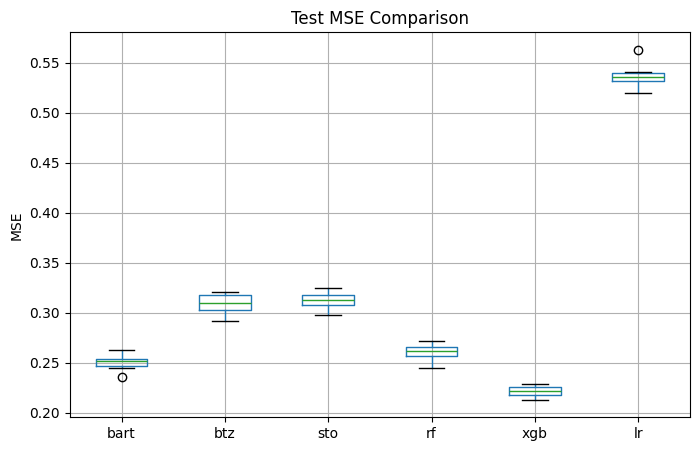

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
test_mse_df.boxplot()
plt.title("Test MSE Comparison")
plt.ylabel("MSE")
plt.grid(True, axis='y')
plt.show()

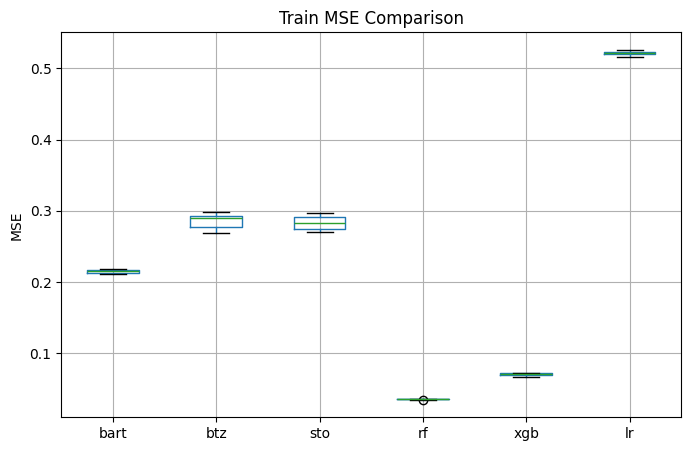

In [14]:
plt.figure(figsize=(8, 5))
train_mse_df.boxplot()
plt.title("Train MSE Comparison")
plt.ylabel("MSE")
plt.grid(True, axis='y')
plt.show()

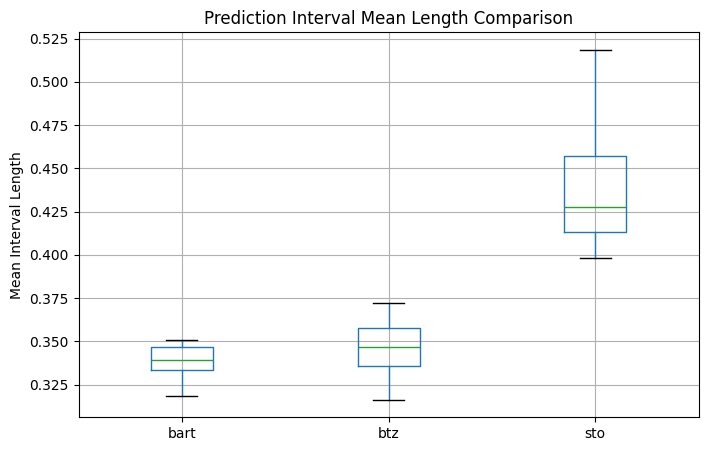

In [15]:
plt.figure(figsize=(8, 5))
pi_length_df.boxplot()
plt.title("Prediction Interval Mean Length Comparison")
plt.ylabel("Mean Interval Length")
plt.grid(True, axis='y')
plt.show()

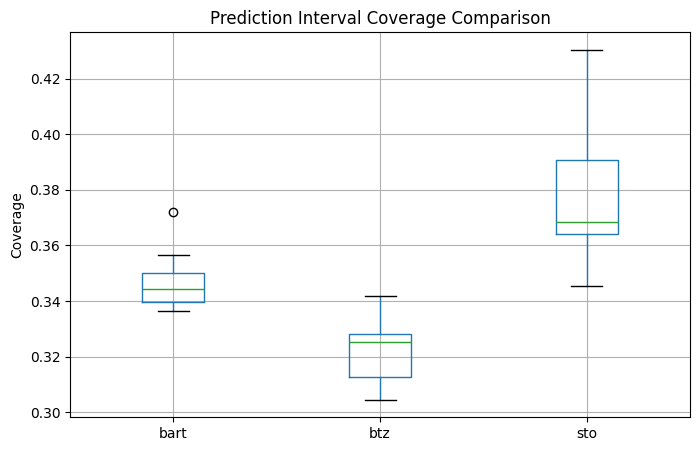

In [16]:
plt.figure(figsize=(8, 5))
coverage_df.boxplot()
plt.title("Prediction Interval Coverage Comparison")
plt.ylabel("Coverage")
plt.grid(True, axis='y')
plt.show()

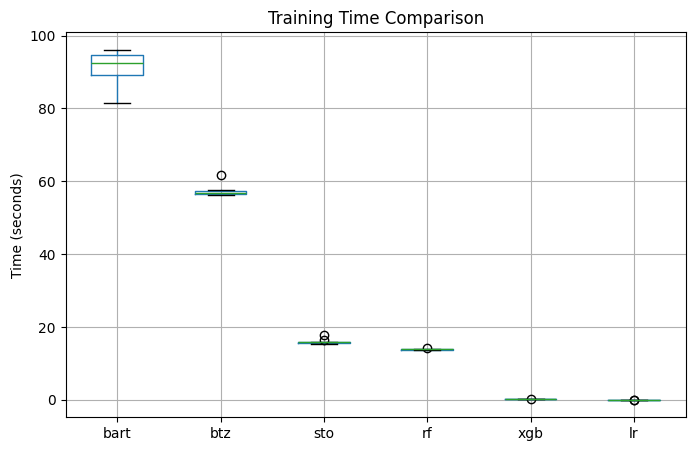

In [17]:
plt.figure(figsize=(8, 5))
time_df.boxplot()
plt.title("Training Time Comparison")
plt.ylabel("Time (seconds)")
plt.grid(True, axis='y')
plt.show()